In [2]:
import tensorflow as tf
from tensorflow.keras import layers, models, Input, Model
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D, BatchNormalization, Activation
import numpy as np

# verify if GPU is available
print(tf.test.is_gpu_available())

# set memory growth to true
physical_devices = tf.config.experimental.list_physical_devices('GPU')
print("Setting memory growth to True for GPU: ", physical_devices[0])
tf.config.experimental.set_memory_growth(physical_devices[0], True)

# dont display much info of tensorflow
tf.get_logger().setLevel('ERROR')


2024-01-11 11:19:13.001396: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-01-11 11:19:13.075435: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-01-11 11:19:13.075482: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-01-11 11:19:13.077841: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-01-11 11:19:13.092546: I tensorflow/core/platform/cpu_feature_guar

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.
True
Setting memory growth to True for GPU:  PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')


2024-01-11 11:19:15.338169: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-01-11 11:19:15.389944: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-01-11 11:19:15.390115: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

In [3]:

# Load data
manta_path = "/home/vm/SSL_Project_1/data/processed/bag_2023-07-04_15-23-48/_manta.npy"
xiris_path = "/home/vm/SSL_Project_1/data/processed/bag_2023-07-04_15-23-48/_xiris.npy"
y_path = "/home/vm/SSL_Project_1/data/processed/bag_2023-07-04_15-23-48/_y.npy"
feats_path = "/home/vm/SSL_Project_1/data/processed/bag_2023-07-04_15-23-48/_feats.npy"

# load numpy arrays and display shapes
manta = np.load(manta_path)
xiris = np.load(xiris_path)
y = np.load(y_path)
print("manta shape: ", manta.shape)
print("xiris shape: ", xiris.shape)
print("y shape: ", y.shape) # laser power and velocity

""" #feats = np.load(feats_path)
#print("feats shape: ", feats.shape)
y = y[:, 0] # only use laser power
print("y shape: ", y.shape)

# normalize y
y = y / np.max(y) """

# use laser power and velocity as labels
y = y[:, :2]
print("y shape: ", y.shape)

# print max of each column
print("max of each column: ", np.max(y, axis=0))
# normalize y by dividing laser power by max of each column
y = y / np.max(y, axis=0)

manta shape:  (9587, 320, 320)
xiris shape:  (9587, 320, 320)
y shape:  (9587, 2)
y shape:  (9587, 2)
max of each column:  [2750   15]


In [4]:

# create a function to encode y
def encode_one_column(y):
    # create a new array of zeros with the same shape as y
    encoded_y = np.zeros(y.shape)
    # get the unique values in y
    unique_values = np.unique(y)
    # loop through the unique values
    for i, value in enumerate(unique_values):
        # find the indices where y equals the unique value
        indices = np.where(y == value)
        # set the indices in encoded_y to i
        encoded_y[indices] = i
    return encoded_y

# create new array to store encoded y
y_encoded = np.zeros(y.shape)
# loop through each column in y and encode it
for i in range(y.shape[1]):
    y_encoded[:, i] = encode_one_column(y[:, i])
    
# convert to int
y_encoded = y_encoded.astype(int)
y_encoded.shape

(9587, 2)

In [5]:
# concatenate manta and xiris images with label y_encoded as rows
# concatenate the two inputs (manta and xiris) along rows
x = np.concatenate((manta, xiris), axis=0)
y = np.concatenate((y_encoded, y_encoded), axis=0)
print("x shape: ", x.shape)
print("y shape: ", y.shape)

# split data into train and test (manta as input and y as output) with shuffle as true
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, shuffle=True, random_state=42)
print("x_train shape: ", X_train.shape)
print("y_train shape: ", y_train.shape)
print("x_test shape: ", X_test.shape)
print("y_test shape: ", y_test.shape)
 

x shape:  (19174, 320, 320)
y shape:  (19174, 2)
x_train shape:  (15339, 320, 320)
y_train shape:  (15339, 2)
x_test shape:  (3835, 320, 320)
y_test shape:  (3835, 2)


In [6]:
del manta, xiris, y, y_encoded, x

In [12]:
y_train

array([[3, 0],
       [3, 0],
       [0, 2],
       ...,
       [2, 0],
       [0, 0],
       [2, 1]])

/home/vm/laser/lib/python3.10/site-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


In [18]:
import tensorflow_addons as tfa
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.models import Model

class SupervisedContrastiveLoss(tf.keras.losses.Loss):
    def __init__(self, temperature=1, name=None):
        super().__init__(name=name)
        self.temperature = temperature

    def __call__(self, labels, feature_vectors, sample_weight=None):
        # Normalize feature vectors
        feature_vectors_normalized = tf.math.l2_normalize(feature_vectors, axis=1)
        # Compute logits
        logits = tf.divide(
            tf.matmul(
                feature_vectors_normalized, tf.transpose(feature_vectors_normalized)
            ),
            self.temperature,
        )
        return tfa.losses.npairs_loss(tf.squeeze(labels), logits)

def create_encoder(input_shape=(320, 320, 1)):
    inputs = Input(shape=input_shape)
    
    x = Conv2D(16, (3, 3), activation='relu')(inputs)
    x = MaxPooling2D((2, 2))(x)
    
    x = Conv2D(32, (3, 3), activation='relu')(x)
    x = MaxPooling2D((2, 2))(x)

    x = Flatten()(x)
    model = Model(inputs=inputs, outputs=x)
    return model

# Add contrastive and regression head
def add_contrastive_head(input_shape, encoder, embedding_dim, num_tasks):
    inputs = Input(shape=input_shape)
    features = encoder(inputs)

    # Add dense layer for each task
    contrastive_outputs = [Dense(embedding_dim, activation='linear', name=f"contrastive_output_{i}")(features) for i in range(num_tasks)]

    model = Model(inputs=inputs, outputs=contrastive_outputs)
    return model

input_shape = (320, 320, 1)
embedding_dim = 128
batch_size = 64
epochs = 20
validation_split = 0.2
learning_rate = 0.001
num_tasks = 2   # P, V
temperature = 0.05

# Build model
encoder = create_encoder()
encoder_with_contrastive_head = add_contrastive_head(input_shape, encoder, embedding_dim, num_tasks)
encoder_with_contrastive_head.summary()

# Compile model
encoder_with_contrastive_head.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
                                      loss=[SupervisedContrastiveLoss(temperature=temperature) for _ in range(num_tasks)],
)
# Fit model
history = encoder_with_contrastive_head.fit(
    x=X_train, 
    y=[y_train[:, 0], y_train[:, 1]],
    batch_size=batch_size, 
    epochs=epochs, 
    validation_split=validation_split,
)


Model: "model_14"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_16 (InputLayer)       [(None, 320, 320, 1)]        0         []                            
                                                                                                  
 model_13 (Functional)       (None, 194688)               4800      ['input_16[0][0]']            
                                                                                                  
 contrastive_output_0 (Dens  (None, 128)                  2492019   ['model_13[0][0]']            
 e)                                                       2                                       
                                                                                                  
 contrastive_output_1 (Dens  (None, 128)                  2492019   ['model_13[0][0]']     

2024-01-11 11:31:43.173287: I external/local_xla/xla/service/service.cc:168] XLA service 0x7f6310238210 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-01-11 11:31:43.173352: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA RTX A6000, Compute Capability 8.6
2024-01-11 11:31:43.185311: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1704972703.379760  666698 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


192/192 [==============================] - 17s 66ms/step - loss: 7.6058 - contrastive_output_0_loss: 3.5436 - contrastive_output_1_loss: 4.0622 - val_loss: 6.8876 - val_contrastive_output_0_loss: 3.2066 - val_contrastive_output_1_loss: 3.6810
Epoch 2/20
192/192 [==============================] - 8s 43ms/step - loss: 6.7276 - contrastive_output_0_loss: 3.1119 - contrastive_output_1_loss: 3.6156 - val_loss: 6.5272 - val_contrastive_output_0_loss: 2.9984 - val_contrastive_output_1_loss: 3.5288
Epoch 3/20
192/192 [==============================] - 8s 43ms/step - loss: 6.4356 - contrastive_output_0_loss: 2.9686 - contrastive_output_1_loss: 3.4671 - val_loss: 6.3710 - val_contrastive_output_0_loss: 2.9228 - val_contrastive_output_1_loss: 3.4482
Epoch 4/20
192/192 [==============================] - 9s 45ms/step - loss: 6.3209 - contrastive_output_0_loss: 2.9227 - contrastive_output_1_loss: 3.3982 - val_loss: 6.2854 - val_contrastive_output_0_loss: 2.9105 - val_contrastive_output_1_loss: 3.374

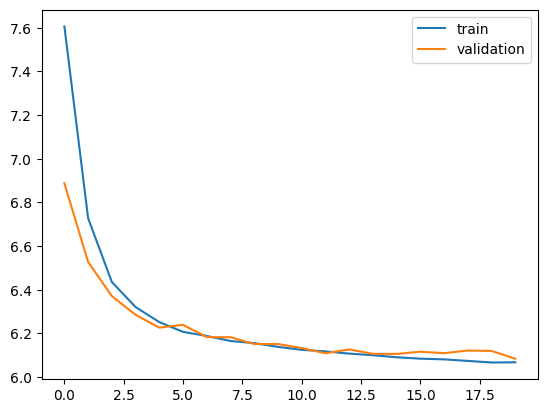

In [19]:
# show training history
import matplotlib.pyplot as plt

plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='validation')
plt.legend()
plt.show()

# get 